In [267]:
import numpy
from matplotlib.pyplot import  plot, figure, imshow
from pandas import *
from typing import Tuple
import matplotlib.pyplot as plt
%pylab inline
from random import shuffle
import time

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


(17, 17)


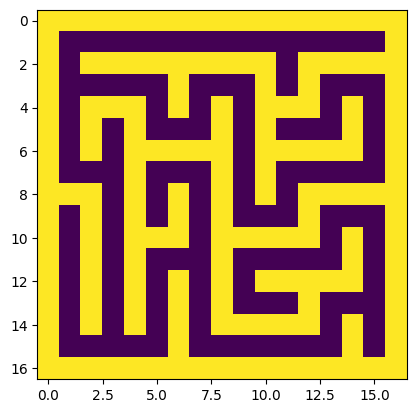

In [268]:
def make_maze(w, h): #Skapa maze
    # Initialisera maze grid
    vis = [[0] * w + [1] for _ in range(h)] + [[1] * (w + 1)]
    ver = [["10"] * w + ['1'] for _ in range(h)] + [[]]
    hor = [["11"] * w + ['1'] for _ in range(h + 1)]

    #Funktion för att gå igenom maze
    def walk(x, y):
        vis[y][x] = 1

        # Definiera alla möjliga drag (vänster, höger, upp, ner) och blanda dem
        d = [(x - 1, y), (x, y + 1), (x + 1, y), (x, y - 1)]
        shuffle(d)
        #Iterera igenom dem blandade dragen
        for (xx, yy) in d: #Kolla ifall draget är giltigt (inte draget)
            if vis[yy][xx]: continue 
            if xx == x: hor[max(y, yy)][x] = "10" # Uppdatera väggarna baserat på det aktuella draget
            if yy == y: ver[y][max(x, xx)] = "00"
            walk(xx, yy)

    walk(numpy.random.randint(w), numpy.random.randint(h))

    #Konvertera maze till en binary mattix
    s = ""
    for (a, b) in zip(hor, ver):
        s += ''.join(a + ['\n'] + b + ['\n'])

    M=[]
    for line in s.split("\n"):
        if line!="":
            R=[]
            for e in line:
                R.append(int(e))
            M.append(R)
    return M

#Generera maze och visa den
maze=numpy.array(make_maze(8,8))
imshow(maze)

print(maze.shape)

In [269]:
print(maze) # 0 = där vi kan gå, 1 = vägg

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1]
 [1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1]
 [1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1]
 [1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1]
 [1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1]
 [1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1]
 [1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1]
 [1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1]
 [1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1]
 [1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1]
 [1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1]
 [1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1]
 [1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


In [270]:
start_position = (1,1) #där vi börjar
end_position = (15,15) #där vi ska sluta

In [271]:
#Implementera agent
#Actions (upp, höger ,vänster, ner)
actions = [(-1, 0), # Upp: Rör sig ett steg upp och sänker rad-index med 1
          (1, 0),   # Ner: Rör sig ett steg ner och höjer rad-index med 1
          (0, -1),  # Vänster: Rör sig ett steg åt vänster, sänker column-index med 1
          (0, 1)]   # Höger: Rör sig ett steg åt höger, höjer column-index med 1 
class QLearningAgent:
                        #------ Q-table för att lagra Q-värden för varje kombination av position och action------
        def __init__(self, maze, start_position, goal_position, learning_rate=1.1, discount_factor=0.9, exploration_start=1.0, exploration_end=0.01, num_episodes=100):
                self.q_table = 0.01 * numpy.ones((maze.shape[0], maze.shape[1], 4))  # 4 actions - upp, ner, vänster, höger
                self.learning_rate = learning_rate
                self.discount_factor = discount_factor
                self.exploration_start = exploration_start
                self.exploration_end = exploration_end
                self.num_episodes = num_episodes
                self.start_position = start_position
                self.goal_position = goal_position

                # ------- Räkna ut nuvarande_episode genom att använda en formel ---------
        def get_exploration_rate(self, current_episode):
                exploration_rate = self.exploration_start * (self.exploration_end / self.exploration_start) ** (current_episode / self.num_episodes)
                return exploration_rate

                # ----- Hämta nuvarande action ----------------
        def get_action(self, state, current_episode): # state är en tuple som representerar vart agenten är i labyrinten (x,y)
                exploration_rate = self.get_exploration_rate(current_episode)
                
                # välja en action för vart den är, antingen slumpmässigt (exploration) eller använda Q-table (explotation)
                if numpy.random.rand() < exploration_rate:
                        return numpy.random.randint(4) # Välja en av actions
                else:
                        return numpy.argmax(self.q_table[state]) # Välja action som har högst Q-value för vart den är
                
        def update_q_table(self, state, action, next_state, reward):
                # Hitta bästa nästa action genom att välja den action som maximerar Q-värdet för nästa steg
                best_next_action = numpy.argmax(self.q_table[next_state])

                # Få tag på nuvarande q-value för aktuella state och action
                current_q_value = self.q_table[state][action]

                # Q-value updateras genom att använda Q-lelarning formel
                new_q_value = current_q_value + self.learning_rate * (reward + self.discount_factor * self.q_table[next_state][best_next_action] - current_q_value)

                # Uppdatera Q-table med den nya Q-value för aktuella state och action
                self.q_table[state][action] = new_q_value

In [272]:
#Reward
goal_reward = 1 #när målet nås
wall_penalty = -1 #straff för att kollidera med vägg
step_penalty = 0 #Straff för vaje steg

In [273]:
#Testning av agenten
#denna funktion simulerar agenten's moves

def finish_episode(agent, maze, start_position, goal_position, current_episode, train=True):
    # Initialisera nuvarande tillstånd till startpositionen
    current_state = start_position
    # Flagga för att kontrollera om episoden är avslutad
    is_done = False
    # Initialisera episodbelöning och stegräknare
    episode_reward = 0
    episode_step = 0
    # Initialisera sökvägen med startpositionen
    path = [current_state]

    # Loopa tills episoden är klar
    while not is_done:
        # Hämta action från agenten för det aktuella tillståndet och episoden
        action = agent.get_action(current_state, current_episode)
        # Beräkna nästa tillstånd baserat på den valda action
        next_state = (current_state[0] + actions[action][0], current_state[1] + actions[action][1])

        # Om nästa tillstånd är utanför labyrinten eller kolliderar med en vägg, tilldela straff och stanna
        if (
            next_state[0] < 0
            or next_state[0] >= maze.shape[0]
            or next_state[1] < 0
            or next_state[1] >= maze.shape[1]
            or maze[next_state[0]][next_state[1]] == 1
        ):
            reward = wall_penalty
            next_state = current_state
        # Om nästa state är målet, tilldela belöning och markera episoden som klar
        elif next_state == goal_position:
            path.append(current_state)
            reward = goal_reward
            is_done = True
        # Om nästa state är inom labyrinten, lägg till det i sökvägen och tilldela belöning för ett steg
        else:
            path.append(current_state)
            reward = step_penalty

        # Ackumulera belöning och öka stegräknaren
        episode_reward += reward
        episode_step += 1

        # Om vi tränar, uppdatera Q-tabellen med den nuvarande state
        if train:
            agent.update_q_table(current_state, action, next_state, reward)

        # Uppdatera nuvarande state till nästa state
        current_state = next_state

        
    # Returnera den samlade belöningen, stegräknaren och sökvägen
    return episode_reward, episode_step, path




Learned path:
(1, 1)-> (1, 1)-> (2, 1)-> (3, 1)-> (4, 1)-> (3, 1)-> (3, 2)-> (3, 1)-> (3, 2)-> (3, 1)-> (3, 2)-> (3, 3)-> (3, 2)-> (3, 1)-> (2, 1)-> (3, 1)-> (2, 1)-> (1, 1)-> (2, 1)-> (1, 1)-> (1, 2)-> (1, 1)-> (2, 1)-> (3, 1)-> (4, 1)-> (5, 1)-> (6, 1)-> (5, 1)-> (4, 1)-> (3, 1)-> (4, 1)-> (3, 1)-> (3, 2)-> (3, 3)-> (3, 2)-> (3, 1)-> (2, 1)-> (3, 1)-> (4, 1)-> (5, 1)-> (6, 1)-> (7, 1)-> (6, 1)-> (7, 1)-> (7, 2)-> (7, 1)-> (6, 1)-> (5, 1)-> (4, 1)-> (3, 1)-> (2, 1)-> (1, 1)-> (1, 2)-> (1, 1)-> (1, 2)-> (1, 3)-> (1, 2)-> (1, 3)-> (1, 4)-> (1, 3)-> (1, 2)-> (1, 1)-> (2, 1)-> (1, 1)-> (2, 1)-> (1, 1)-> (2, 1)-> (1, 1)-> (2, 1)-> (1, 1)-> (1, 2)-> (1, 1)-> (2, 1)-> (1, 1)-> (2, 1)-> (1, 1)-> (2, 1)-> (1, 1)-> (2, 1)-> (1, 1)-> (1, 2)-> (1, 1)-> (1, 2)-> (1, 3)-> (1, 2)-> (1, 3)-> (1, 2)-> (1, 1)-> (1, 2)-> (1, 3)-> (1, 2)-> (1, 1)-> (1, 2)-> (1, 3)-> (1, 2)-> (1, 3)-> (1, 2)-> (1, 3)-> (1, 2)-> (1, 1)-> (1, 2)-> (1, 1)-> (2, 1)-> (3, 1)-> (3, 2)-> (3, 1)-> (2, 1)-> (3, 1)-> (4, 1)-> (5, 1

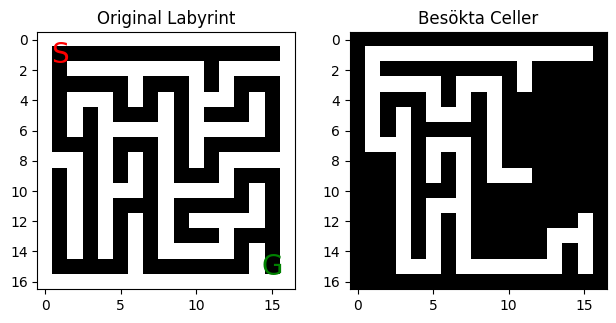

Epok 1/50, Tid: 0.16s, Belöning: -11298, Steg: 22463
Epok 2/50, Tid: 0.01s, Belöning: -708, Steg: 1481
Epok 3/50, Tid: 0.01s, Belöning: -431, Steg: 950
Epok 4/50, Tid: 0.02s, Belöning: -1553, Steg: 3592
Epok 5/50, Tid: 0.00s, Belöning: -98, Steg: 255
Epok 6/50, Tid: 0.00s, Belöning: -246, Steg: 651
Epok 7/50, Tid: 0.00s, Belöning: -86, Steg: 275
Epok 8/50, Tid: 0.00s, Belöning: -115, Steg: 318
Epok 9/50, Tid: 0.00s, Belöning: -52, Steg: 185
Epok 10/50, Tid: 0.00s, Belöning: -146, Steg: 469
Epok 11/50, Tid: 0.00s, Belöning: -41, Steg: 126
Epok 12/50, Tid: 0.00s, Belöning: -65, Steg: 184
Epok 13/50, Tid: 0.00s, Belöning: -45, Steg: 128
Epok 14/50, Tid: 0.00s, Belöning: -54, Steg: 249
Epok 15/50, Tid: 0.00s, Belöning: -70, Steg: 341
Epok 16/50, Tid: 0.00s, Belöning: -20, Steg: 115
Epok 17/50, Tid: 0.00s, Belöning: -16, Steg: 115
Epok 18/50, Tid: 0.00s, Belöning: -22, Steg: 119
Epok 19/50, Tid: 0.00s, Belöning: -19, Steg: 98
Epok 20/50, Tid: 0.00s, Belöning: -110, Steg: 437
Epok 21/50, Tid

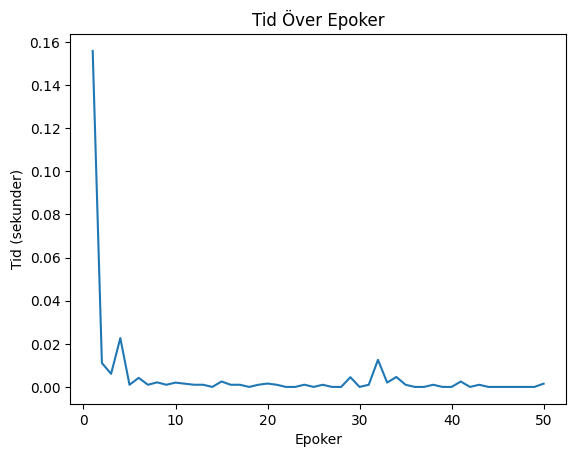

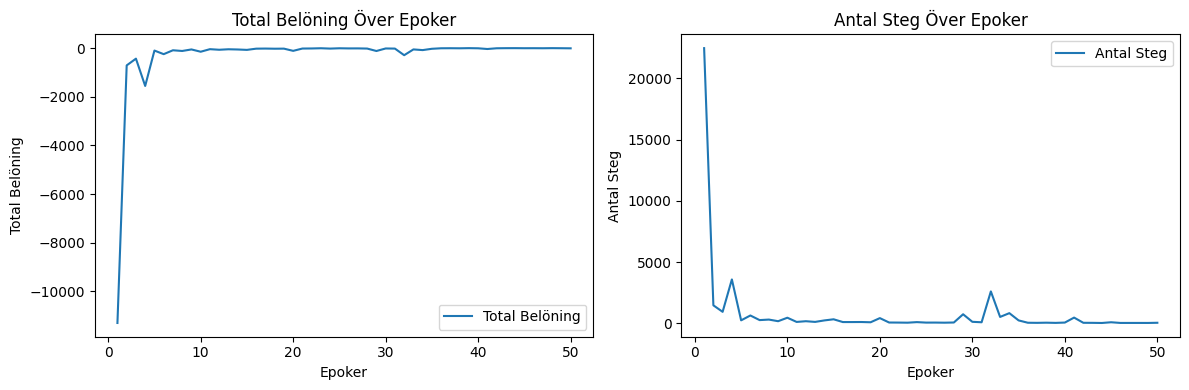

In [274]:

# Denna funktion utvärderar prestandan hos en agent i labyrinten. Funktionen simulerar agentens rörelser i labyrinten,
# uppdaterar dess tillstånd, ackumulerar belöningar och avgör slutet av episoden när agenten når målpositionen.
# Agentens inlärda sökväg skrivs sedan ut tillsammans med det totala antalet steg som tagits och den totala belöningen
# som erhållits under simuleringen. 

def test_agent(agent, maze, num_episodes=1):
    episode_reward, episode_step, path = finish_episode(agent, maze, start_position=(1, 1), goal_position=(15, 15), current_episode=num_episodes, train=False)

    #skriver ut vilket path den har tagit
    print("Learned path:")
    for row, col in path:
        print(f"({row}, {col})-> ", end='')
    print("Goal!")

    #skriver ut totala steg och reward
    print("Number of steps:", episode_step)
    print("total reward:", episode_reward)

    # Rensa befintlig plot om det finns någon
    if plt.gcf().get_axes():
        plt.clf()

    # Skapa subplots (1 rad, 2 kolumner)
    plt.subplot(1, 2, 1)
    plt.imshow(maze, cmap='gray')
    plt.title('Original Labyrint')
    plt.text(agent.start_position[0], agent.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
    plt.text(agent.goal_position[0], agent.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)
    

    plt.subplot(1, 2, 2)
    # Antag att 'visited' är en matris av samma storlek som labyrinten
    visited = numpy.zeros_like(maze)
    for position in path:
        visited[position[0], position[1]] = 1
    visited[agent.goal_position[0], agent.goal_position[1]] = 1  # Markera den avslutade cellen
    plt.imshow(visited, cmap='gray', vmax=1)
    plt.title('Besökta Celler')

    # Justera layouten för att förhindra överlappning
    plt.tight_layout()

    plt.show()

    return episode_step, episode_reward

# Denna funktion tränar agenten genom att simulera flera episoder och uppdatera dess Q-tabell.
def train_agent(agent, maze, num_epochs=50):
    epoch_times = []
    epoch_rewards = []
    epoch_steps = []

    for epoch in range(num_epochs):
        start_time = time.time()
        episode_reward, episode_step, _ = finish_episode(agent, maze, start_position=(1, 1), goal_position=(15, 15), current_episode=epoch)
        epoch_times.append(time.time() - start_time)
        epoch_rewards.append(episode_reward)
        epoch_steps.append(episode_step)
        exploration_rate = agent.get_exploration_rate(epoch)
        
        #skriver ut varje epoch 
        print(f"Epok {epoch + 1}/{num_epochs}, Tid: {epoch_times[-1]:.2f}s, Belöning: {episode_reward}, Steg: {episode_step}")

    # Plotta tid över epoker
    plt.plot(range(1, num_epochs + 1), epoch_times)
    plt.title('Tid Över Epoker')
    plt.xlabel('Epoker')
    plt.ylabel('Tid (sekunder)')
    plt.show()

    # Plotta total belöning och antal steg över epoker
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), epoch_rewards, label='Total Belöning')
    plt.title('Total Belöning Över Epoker')
    plt.xlabel('Epoker')
    plt.ylabel('Total Belöning')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), epoch_steps, label='Antal Steg')
    plt.title('Antal Steg Över Epoker')
    plt.xlabel('Epoker')
    plt.ylabel('Antal Steg')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Skapa en Q-learning agent med labyrinten och start- och målpositionerna
agent = QLearningAgent(maze, start_position=(1, 1), goal_position=(15, 15))
# Testa agenten med test_agent-funktionen
test_agent(agent, maze)
# Träna agenten med train_agent-funktionen
train_agent(agent, maze, num_epochs=50)s
